# Texture and hyperchromatic areas feature exploration

In [39]:
import pandas as pd
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import flood_fill
from skimage import io, color, exposure, img_as_ubyte
from skimage.feature import graycomatrix, graycoprops
from sklearn.cluster import KMeans, MeanShift
from skimage.measure import label, regionprops
from scipy.stats import skew

In [2]:
#Uncomment to install dependecy
!pip install opencv-python 

In [3]:
pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


### Declare variables and lists

In [27]:
# Images root directorie
data_dir = "cancerSeno_bw/train"
output_dir = "featuresTest"

# Class list
classes = ["sano", "cancer"]

# Create output directories
os.makedirs(os.path.join(output_dir, "sano"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "cancer"), exist_ok=True)

# Define angles and distanxes for GLCM (Gray-Level Co-Occurrence Matrix)
angles = [0]
distances = [1]

# Define normalization threshold
treshold = 120

# Define max number of clusters for segmentation
max_clusters = 5

# Initialize lists
# Store texture and density of pixels characteristics
glcm_features = []
densidades_pixeles_oscuros = []
num_cúmulos = []

# Store coordinates of origins in clusters
cluster_seeds = []

# Store loaded images
loaded_images = []

In [18]:
# Accumulate histograms, GLCM features, and dark pixel densities
histograms = {cls: [] for cls in classes}
glcm_features_all = {cls: [] for cls in classes}
dark_pixel_densities = {cls: [] for cls in classes}
brightness_values = {cls: [] for cls in classes}
std_deviation_values = {cls: [] for cls in classes}
skewness_values = {cls: [] for cls in classes}

In [29]:
# Create output directories
for cls in classes:
    class_output_dir = os.path.join(output_dir, cls)
    os.makedirs(os.path.join(class_output_dir, "histogram"), exist_ok=True)
    os.makedirs(os.path.join(class_output_dir, "glcmMatrix"), exist_ok=True)
    os.makedirs(os.path.join(class_output_dir, "pixelDensity"), exist_ok=True)
    os.makedirs(os.path.join(class_output_dir, "brightness"), exist_ok=True)
    os.makedirs(os.path.join(class_output_dir, "stdDeviation"), exist_ok=True)
    os.makedirs(os.path.join(class_output_dir, "skewness"), exist_ok=True)
    os.makedirs(class_output_dir, exist_ok=True)

In [28]:
for cls in classes:
   
os.makedirs(class_output_dir, exist_ok=True)

In [9]:
#Get all images from a directory
def get_images(class_dir):
    file_list = os.listdir(class_dir)
    images = [os.path.join(class_dir, image_name) for image_name in file_list]
    return images

### Obtain images from directories

In [31]:
# Iterate over classes
for cls in classes:
    # Obtain route from current directory
    class_dir = os.path.join(data_dir, cls)
    images = get_images(class_dir)

    # Add image paths to the loaded-images list
    loaded_images.extend(images)
print("Images loaded")

Images loaded


In [32]:
len(loaded_images)

194266

In [6]:
def calculate_glcm(image):
    """Calculate the GLCM properties of an image."""
    normalized_image = image / 255.0
    gray_image_uint8 = np.uint8(normalized_image * 255)
    
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    
    glcm = graycomatrix(gray_image_uint8, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    
    properties = ['contrast', 'correlation', 'energy', 'homogeneity']
    glcm_features = {prop: graycoprops(glcm, prop) for prop in properties}
    return glcm_features

In [22]:
def save_glcm_to_csv(glcm_features_list, output_path):
    """Save the GLCM features list to a CSV file."""
    df = pd.DataFrame(glcm_features_list)
    df.to_csv(output_path, index=False)

In [25]:
for cls in classes:
    for image_path in loaded_images:
        image_name = os.path.basename(image_path).split('.')[0]
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # GLCM
        glcm_features = calculate_glcm(image)
        glcm_features_all[cls].append(glcm_features)

print("GLCM generated")
# Save all GLCM features to a CSV file for each class
for cls in classes:
    combined_glcm_output_path = os.path.join(output_dir, cls, "glcmMatrix", "combined_glcm.csv")
    save_glcm_to_csv(glcm_features_all[cls], combined_glcm_output_path)
    
print("GLCM saved")

GLCM generated


NameError: name 'pd' is not defined

In [12]:
def calculate_dark_pixel_density(image, treshold):
    """Calculate the density of dark pixels in hyperchromatic areas of an image."""
    _, binary_image = cv2.threshold(image, treshold, 255, cv2.THRESH_BINARY)
    dark_pixels_count = np.sum(binary_image == 0)
    total_area = np.sum(binary_image == 255)
    dark_pixels_density = dark_pixels_count / total_area if total_area > 0 else 0
    return dark_pixels_density

In [14]:
def save_pixel_density_to_csv(pixel_densities, output_path):
    """Save the pixel densities list to a CSV file."""
    df = pd.DataFrame(pixel_densities, columns=['pixel_density'])
    df.to_csv(output_path, index=False)

In [23]:
def save_to_csv(data_list, output_path, column_name):
    """Save the data list to a CSV file."""
    df = pd.DataFrame(data_list, columns=[column_name])
    df.to_csv(output_path, index=False)

In [24]:
for cls in classes:
    for image_path in images:
        image_name = os.path.basename(image_path).split('.')[0]
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Dark pixel density
        dark_pixel_density = calculate_dark_pixel_density(image, treshold)
        dark_pixel_densities[cls].append(dark_pixel_density)
    print("first class generated")
print("second class generated")

# Save all dark pixel densities to a CSV file for each class
for cls in classes:
    combined_pixel_density_output_path = os.path.join(output_dir, cls, "pixelDensity", "combined_pixel_density.csv")
    save_pixel_density_to_csv(dark_pixel_densities[cls], combined_pixel_density_output_path)
print("pixel densities saved")

first class generated
first class generated
second class generated
pixel densities saved


In [25]:
def calculate_brightness(image):
    """Calculate the brightness of an image."""
    return np.mean(image)

In [33]:
for cls in classes:
    for image_path in images:
        image_name = os.path.basename(image_path).split('.')[0]
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Brightness
        brightness = calculate_brightness(image)
        brightness_values[cls].append(brightness)
    print("first class generated")
print("second class generated")

# Save all brightness values to a CSV file for each class
for cls in classes:
    combined_brightness_output_path = os.path.join(output_dir, cls, "brightness", "combined_brightness.csv")
    save_to_csv(brightness_values[cls], combined_brightness_output_path, "brightness")
print("brightness saved")

first class generated
first class generated
second class generated
brightness saved


In [35]:
def calculate_std_deviation(image):
    """Calculate the standard deviation of an image."""
    return np.std(image)

In [37]:
for cls in classes:
    for image_path in images:
        image_name = os.path.basename(image_path).split('.')[0]
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Standard deviation
        std_deviation = calculate_std_deviation(image)
        std_deviation_values[cls].append(std_deviation)
    print("first class generated")
print("second class generated")
                                         
# Save all standard deviation values to a CSV file for each class
for cls in classes:
    combined_std_deviation_output_path = os.path.join(output_dir, cls, "stdDeviation", "combined_std_deviation.csv")
    save_to_csv(std_deviation_values[cls], combined_std_deviation_output_path, "std_deviation")
print("std deviation saved")

first class generated
first class generated
second class generated
std deviation saved


In [38]:
def calculate_skewness(image):
    """Calculate the skewness of an image."""
    return skew(image.flatten())

In [ ]:
for cls in classes:
    for image_path in images:
        image_name = os.path.basename(image_path).split('.')[0]
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Skewness
        skewness = calculate_skewness(image)
        skewness_values[cls].append(skewness)
    print("first class generated")
print("second class generated")

# Save all skewness values to a CSV file for each class
for cls in classes:
    combined_skewness_output_path = os.path.join(output_dir, cls, "skewness", "combined_skewness.csv")
    save_to_csv(skewness_values[cls], combined_skewness_output_path, "skewness")
print("skewness saved")

In [ ]:
def density_histogram(image):
    """Calculate the intensity histogram of an image."""
    histogram, _ = np.histogram(image, bins=256, range=(0, 255))
    return histogram

In [ ]:
for image_path in loaded_images:
        image_name = os.path.basename(image_path).split('.')[0]
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        # Histogram
        histogram = density_histogram(image)
        histograms[cls].append(histogram)
        
         # Save individual histograms
        histogram_output_path = os.path.join(output_dir, cls, "histogram", f"histogram-{image_name}.png")
        plt.plot(histogram)
        plt.title(f'Histograma de Intensidad - {image_name}')
        plt.xlabel('Intensidad')
        plt.ylabel('Frecuencia')
        plt.savefig(histogram_output_path)
        plt.close()
print("Histograms saved")

In [6]:
# Print loaded images paths
print("Nombres de las imágenes cargadas:")
for image_path in loaded_images:
    print(os.path.basename(image_path))

Nombres de las imágenes cargadas:
10253_idx5_x1001_y1001_class0.png
10253_idx5_x1001_y1051_class0.png
10253_idx5_x1001_y1101_class0.png
10253_idx5_x501_y351_class1.png
10253_idx5_x551_y301_class1.png
10253_idx5_x551_y351_class1.png


#### Density histogram

In [7]:
def density_histogram(image):  

    # Normalize image
    imagen_normalizada = image / 255.0
            
    # Calculate image intensity range
    min_intensity = np.min(image)
    max_intensity = np.max(image)
            
    # Calculate intensity histogram for image with adjusted bins
    histogram = np.histogram(image, bins=np.arange(min_intensity, max_intensity+1), range=(min_intensity, max_intensity))[0]
   
    # Show histogram
    plt.plot(histogram)
    plt.title('Histograma de Intensidad de la Imagen')
    plt.xlabel('Intensidad')
    plt.ylabel('Frecuencia')
    plt.show()

10253_idx5_x1001_y1001_class0.png


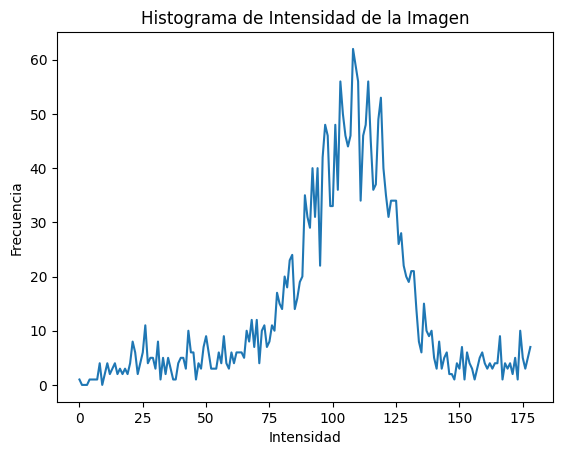

10253_idx5_x1001_y1051_class0.png


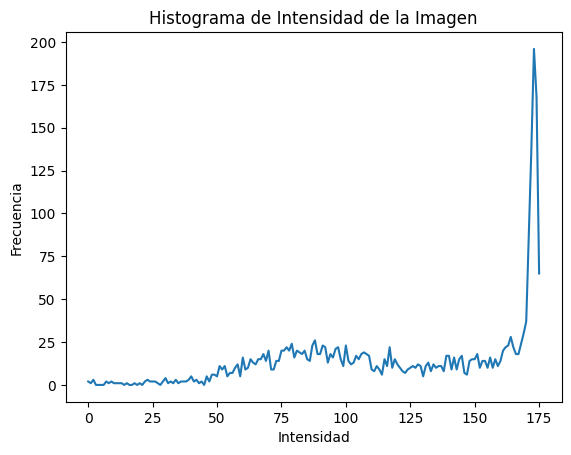

10253_idx5_x1001_y1101_class0.png


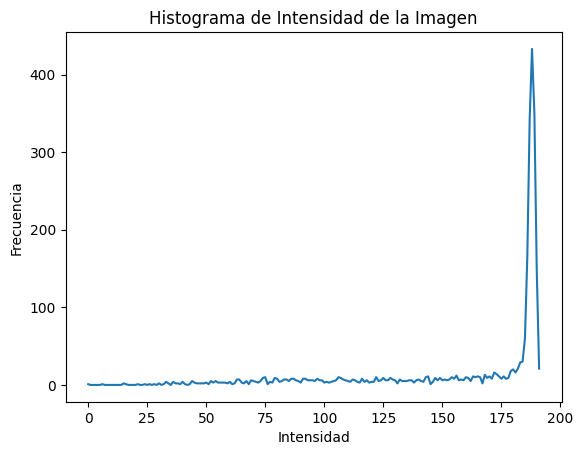

10253_idx5_x501_y351_class1.png


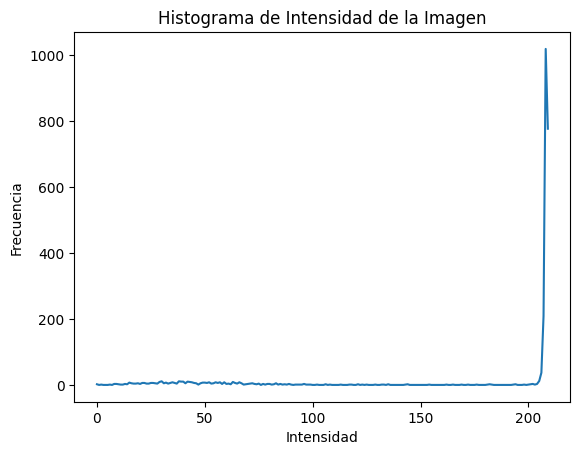

10253_idx5_x551_y301_class1.png


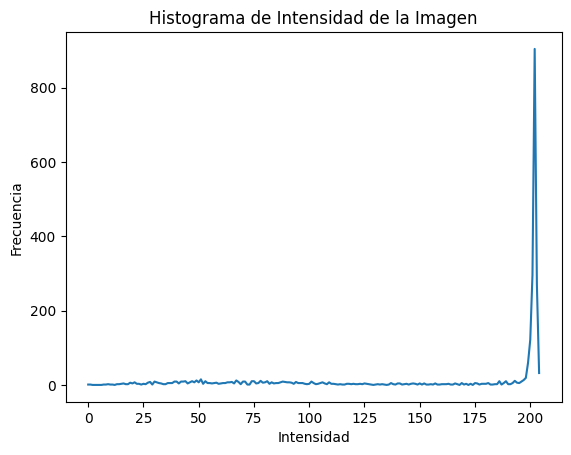

10253_idx5_x551_y351_class1.png


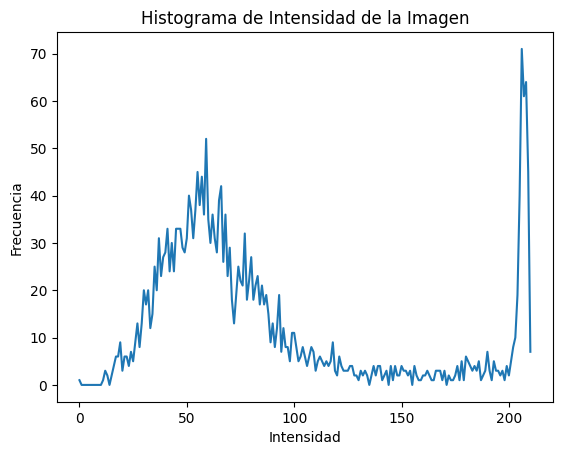

In [8]:
for image_path in loaded_images:
    print(os.path.basename(image_path))
    gray_image = io.imread(image_path)
    density_histogram(gray_image)

#### GLCM Matrix

In [9]:
def calculate_glcm(image):
    
    # Normalize image
    normalized_image = gray_image / 255.0
    
    # Define GLCM parameters
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    
    # Transform image into unsigned int
    gray_image_uint8 = np.uint8(normalized_image * 255)
    
    # Calculate GLCM
    glcm = graycomatrix(gray_image_uint8, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    
    # Calculate GLCM properties
    properties = ['contrast', 'correlation', 'energy', 'homogeneity']
    glcm_features = []
    for prop in properties:
        glcm_features.append(graycoprops(glcm, prop))
    
    # Print texture characteristics
    print("Propiedades de la GLCM:")
    for i, prop in enumerate(properties):
        print(f"{prop}: {glcm_features[i]}")
    print("***")
    return glcm

In [10]:
for image_path in loaded_images:
    print(os.path.basename(image_path))
    gray_image = io.imread(image_path)
    calculate_glcm(gray_image)

10253_idx5_x1001_y1001_class0.png
Propiedades de la GLCM:
contrast: [[405.67591837 732.82632237 607.71795918 624.8363182 ]]
correlation: [[0.77111414 0.58189973 0.65574473 0.64369935]]
energy: [[0.02235043 0.02145849 0.0215265  0.02123094]]
homogeneity: [[0.08149514 0.07318528 0.07856066 0.07212296]]
***
10253_idx5_x1001_y1051_class0.png
Propiedades de la GLCM:
contrast: [[ 490.10571429 1095.05247813 1015.0755102  1094.4606414 ]]
correlation: [[0.87205778 0.71222431 0.73217256 0.7123003 ]]
energy: [[0.04964598 0.04006352 0.04373256 0.04162223]]
homogeneity: [[0.14631024 0.1080291  0.11854621 0.11641638]]
***
10253_idx5_x1001_y1101_class0.png
Propiedades de la GLCM:
contrast: [[ 676.87755102 1349.45522699 1115.95836735 1374.9154519 ]]
correlation: [[0.79352418 0.57939531 0.65261256 0.57115817]]
energy: [[0.1176424  0.11228913 0.11615168 0.11283966]]
homogeneity: [[0.28919757 0.27310873 0.2769872  0.28468728]]
***
10253_idx5_x501_y351_class1.png
Propiedades de la GLCM:
contrast: [[282.47

#### Pixel density

In [11]:
def dark_pixel_density(image, treshold):
    # Apply thresholding to identify hyperchromatic areas
    _, binary_image = cv2.threshold(image, treshold, 255, cv2.THRESH_BINARY)

    # Calculte the amount of dark pixeles within the hyperchromatic area
    dark_pixels_count = np.sum(binary_image == 0)

    # Calculate the total area of the hyperchromatic areas
    total_area = np.sum(binary_image == 255)

    # Calculate the density of the dark pixels
    dark_pixels_density = dark_pixels_count / total_area

    print(f"Densidad de píxeles oscuros en áreas hipercromáticas: {dark_pixels_density}")
    
    return dark_pixels_density

10253_idx5_x1001_y1001_class0.png
Densidad de píxeles oscuros en áreas hipercromáticas: 0.07898144151920587


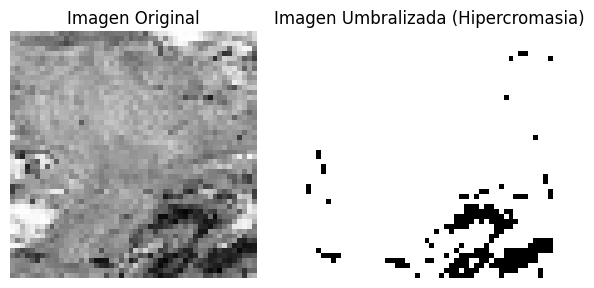

10253_idx5_x1001_y1051_class0.png
Densidad de píxeles oscuros en áreas hipercromáticas: 0.029230135858377932


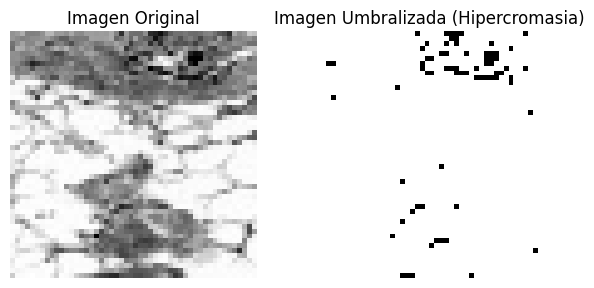

10253_idx5_x1001_y1101_class0.png
Densidad de píxeles oscuros en áreas hipercromáticas: 0.035196687370600416


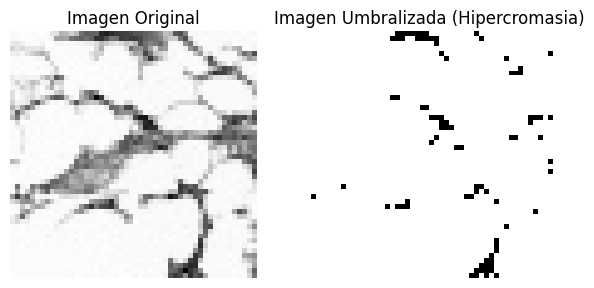

10253_idx5_x501_y351_class1.png
Densidad de píxeles oscuros en áreas hipercromáticas: 0.17150890346766634


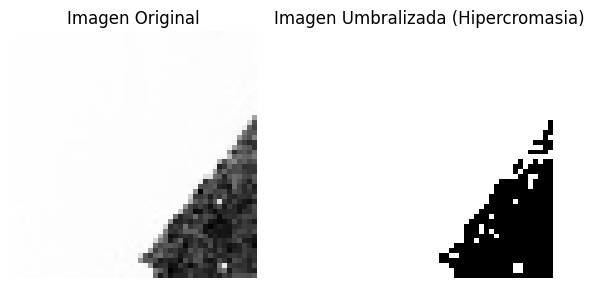

10253_idx5_x551_y301_class1.png
Densidad de píxeles oscuros en áreas hipercromáticas: 0.15955473098330242


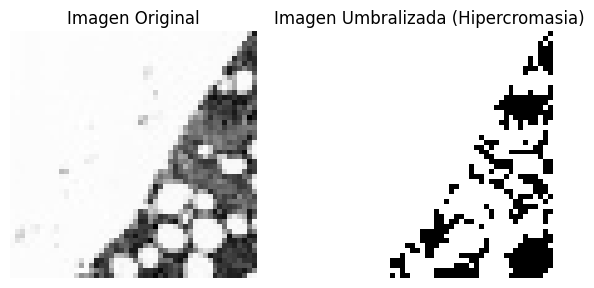

10253_idx5_x551_y351_class1.png
Densidad de píxeles oscuros en áreas hipercromáticas: 1.5693730729701953


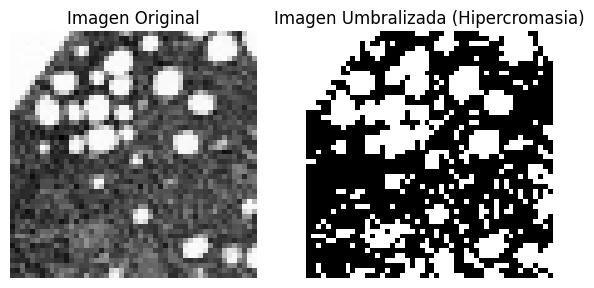

In [12]:
for image_path in loaded_images:
    print(os.path.basename(image_path))
    gray_image = io.imread(image_path)
    
    dpd = dark_pixel_density(gray_image, treshold)

    #Obtain binary image
    _, binary_image = cv2.threshold(gray_image, treshold, 255, cv2.THRESH_BINARY)
    
    # Configure sub grapghics so they are shown side by side
    fig, axs = plt.subplots(1, 2, figsize=(7, 7))

    # Show original image
    axs[0].imshow(gray_image, cmap='gray')
    axs[0].set_title('Imagen Original')
    axs[0].axis('off')

    # Show treholded image
    axs[1].imshow(binary_image, cmap='gray')
    axs[1].set_title('Imagen Umbralizada (Hipercromasia)')
    axs[1].axis('off')

    plt.show()
    

#### Hipercomatic zones or clusters

In [6]:
def encontrar_cumulos(imagen):
    # Etiquetar regiones conectadas
    etiquetas = label(imagen)
    
    # Obtener propiedades de las regiones etiquetadas
    propiedades = regionprops(etiquetas)
    
    # Contar el número de cúmulos y almacenar sus coordenadas
    num_cumulos = len(propiedades)
    coordenadas_cumulos = [(prop.centroid[0], prop.centroid[1]) for prop in propiedades]
    
    return num_cumulos, coordenadas_cumulos

In [7]:
for image_path in loaded_images:
    print(os.path.basename(image_path))
    gray_image = io.imread(image_path)
    num_cumulos, coordenadas_cumulos = encontrar_cumulos(gray_image)
    print("Número de cúmulos:", num_cumulos)
    print("Coordenadas de los cúmulos:", coordenadas_cumulos)

10253_idx5_x1001_y1001_class0.png
Número de cúmulos: 2265
Coordenadas de los cúmulos: [(0.0, 0.0), (0.0, 1.0), (0.0, 2.0), (0.0, 3.0), (0.0, 4.0), (0.0, 5.0), (0.0, 6.0), (0.0, 7.0), (0.0, 8.0), (0.0, 9.0), (0.0, 10.0), (0.0, 11.0), (0.0, 12.0), (0.0, 13.0), (0.0, 14.0), (0.0, 15.0), (0.0, 16.0), (0.0, 17.0), (0.5, 18.5), (0.0, 19.0), (0.0, 20.0), (0.0, 21.0), (0.0, 22.0), (0.0, 23.0), (0.0, 24.0), (0.0, 25.0), (0.0, 26.0), (0.0, 27.0), (0.0, 28.0), (0.0, 29.0), (0.0, 30.0), (0.0, 31.0), (0.0, 32.0), (0.0, 33.0), (0.5, 34.5), (0.0, 35.0), (0.5, 36.0), (0.0, 37.0), (0.0, 38.0), (0.0, 39.0), (0.0, 40.0), (0.0, 41.0), (0.0, 42.0), (0.0, 43.0), (0.5, 44.0), (0.0, 45.0), (0.0, 46.0), (0.0, 47.0), (0.0, 48.0), (0.0, 49.0), (1.0, 0.0), (1.0, 1.0), (1.0, 2.0), (1.0, 3.0), (1.0, 4.0), (1.0, 5.0), (1.0, 6.0), (1.0, 7.0), (1.0, 8.0), (1.0, 9.0), (1.0, 10.0), (1.0, 11.0), (1.0, 12.0), (1.0, 13.0), (1.5, 13.5), (1.0, 15.0), (1.0, 16.0), (1.0, 17.0), (1.0, 18.0), (1.0, 20.0), (1.0, 21.0), (1.0, 22.0